In [1]:
pip install xgboost

     |████████████████████████████████| 166.7 MB 63 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


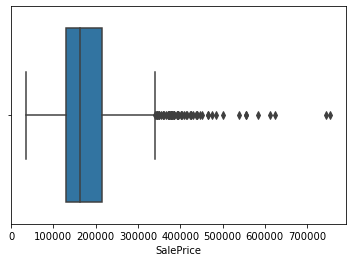

In [5]:
sns.boxplot(data['SalePrice'])

Из боксплота становится очевидно, что мы столкнемся с трудностями при валидаци. Можно предположить, что на кросс-валидации нас ждет здоровенный разброс метрики

In [6]:
X = data[['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']]
y = data['SalePrice']

In [7]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.4, random_state=0)

In [8]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = X_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 15 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 15].index)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        5
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          6
Exterior1st      14
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           5
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        6
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            2
Fence             4
MiscFeature       3
SaleType          9
SaleCondition     6
dtype: int64


In [9]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([X_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [10]:
#наши фолды
kf = KFold(n_splits=10, shuffle=True, random_state=11)

In [11]:
for train, test in kf.split(X):
    print("%s %s" %(train,test))

[   0    1    2 ... 1455 1456 1458] [  22   36   39   42   43   53   61   70   73   80   82   88   93  107
  117  123  127  130  135  164  177  194  195  201  217  220  237  246
  262  272  279  288  293  304  311  316  319  325  326  331  333  348
  368  369  371  411  427  433  434  447  455  461  464  480  488  500
  535  548  549  553  561  563  590  591  592  605  607  610  615  616
  618  632  659  673  700  701  707  713  730  736  809  819  820  841
  869  873  880  896  901  907  913  915  919  936  950  961  964  985
 1016 1018 1024 1042 1045 1046 1053 1057 1072 1090 1100 1110 1128 1131
 1136 1144 1181 1204 1208 1246 1251 1256 1257 1262 1291 1292 1296 1300
 1311 1319 1320 1323 1324 1346 1356 1372 1392 1395 1401 1402 1414 1422
 1428 1438 1442 1449 1457 1459]
[   0    1    3 ... 1457 1458 1459] [   2   25   26   38   41   44   46   60   66   67   77   83   92  128
  148  169  175  181  189  214  216  221  239  245  247  250  253  255
  259  277  289  292  294  309  317  320  32

### случайный лес

In [12]:
from sklearn.ensemble import RandomForestRegressor
rand_for_clf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=10, min_samples_split=20, min_samples_leaf=10, max_features=20, n_jobs=-1)
rand_forest = rand_for_clf.fit(X_train, y_train).score(X_test, y_test)
rand_forest 

0.8094158793102736

([<matplotlib.axis.YTick at 0x7fad315e2e10>,
 <a list of 221 Text yticklabel objects>)

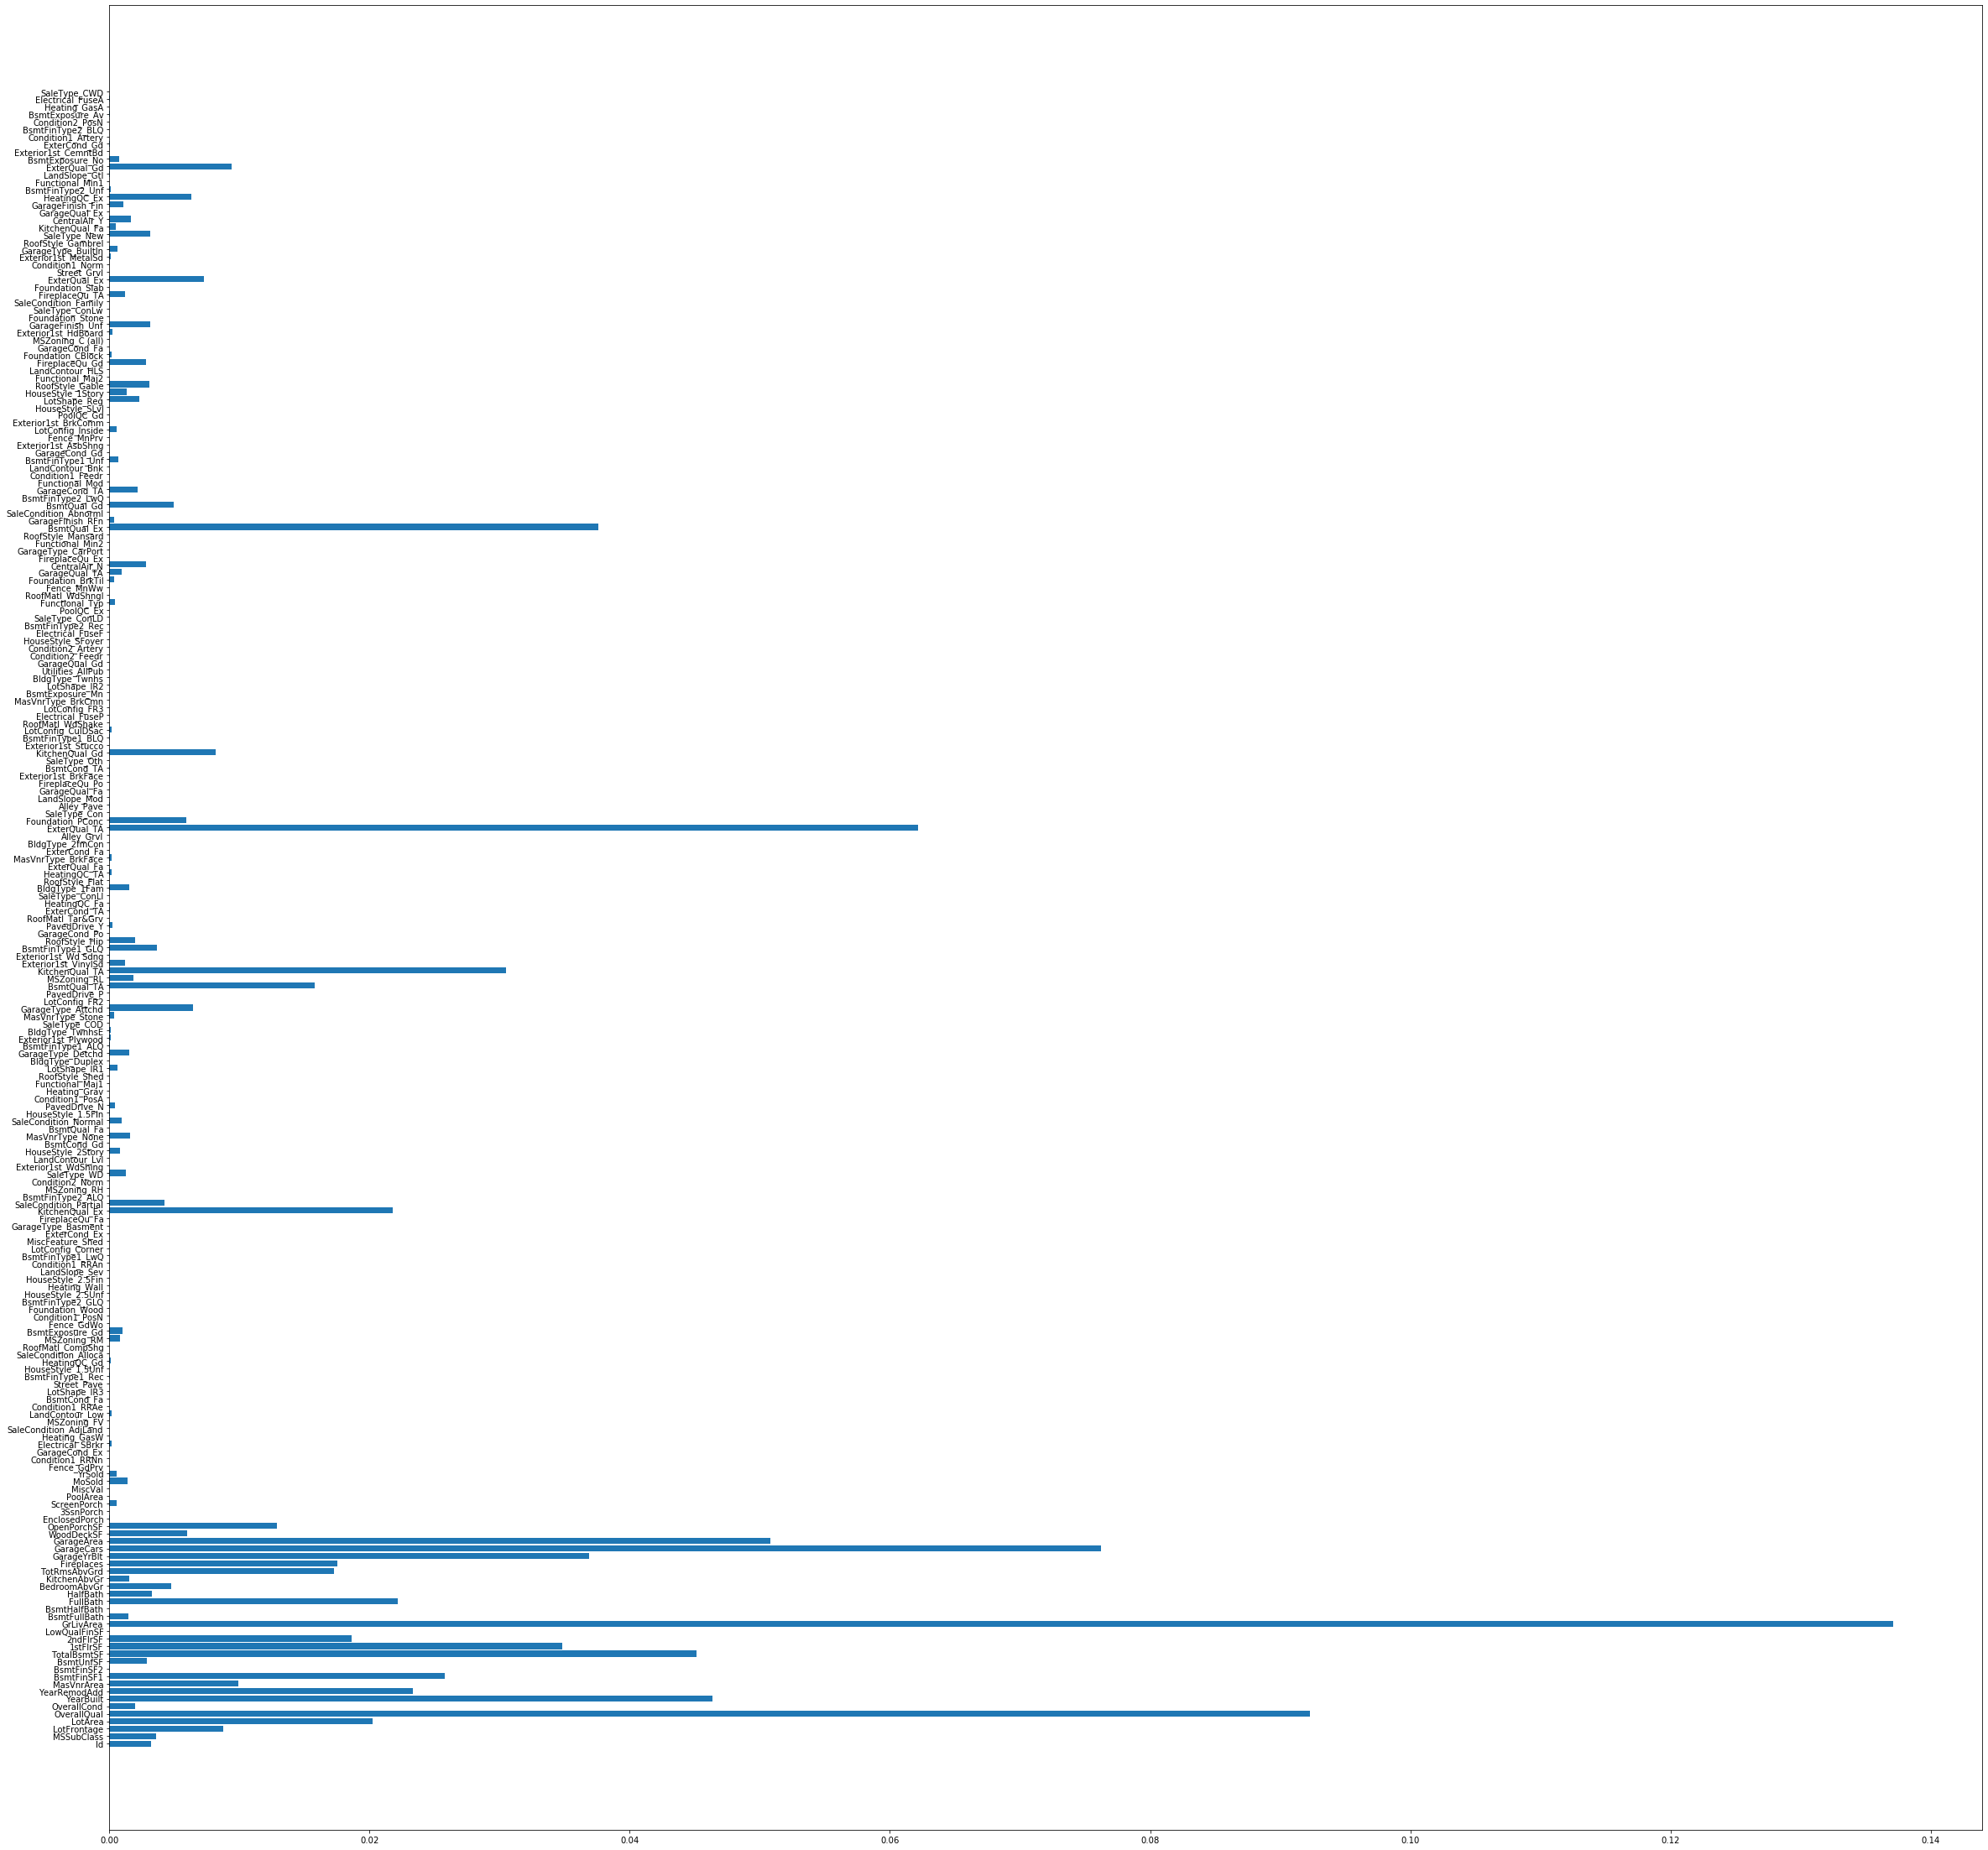

In [15]:
# важность признаков
import matplotlib.pyplot as plt 

plt.figure(figsize=(40, 40))
plt.barh(np.arange(len(rand_for_clf.feature_importances_)), rand_for_clf.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns)

### стекинг

In [14]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [16]:
estimators = [
    ('lr', LinearRegression()),
    ('kn', KNeighborsRegressor()),
    ('dt', DecisionTreeRegressor()),
    ('svm', SVR())
]

In [17]:
regressor = StackingRegressor(
    estimators=estimators, 
    final_estimator=RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=10, min_samples_split=20, min_samples_leaf=10, n_jobs=-1)
)

In [18]:
stacking_clf = regressor.fit(X_train, y_train).score(X_test, y_test)
stacking_clf

0.8233117024579558

In [27]:
from sklearn.ensemble import BaggingRegressor

In [28]:
bagging_clf = BaggingRegressor(n_estimators=25,  n_jobs=-1)
bagging = bagging_clf.fit(X_train, y_train).score(X_test, y_test)
bagging

0.848099956047969

In [66]:
#Запишем все наши результаты в словарь для сравнения
hold_out = {'random forest':rand_forest, 'stacking':stacking_clf, 'bagging':bagging}
max_ ={k:v for k, v in hold_out.items() if v == max(hold_out.values())}
print(f'В данном примере лучшая модель для оценки данных: {max_}')

В данном примере лучшая модель для оценки данных: {'bagging': 0.848099956047969}
